In [76]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

In [77]:
# Import the data sets
adv = pd.read_excel('https://github.com/danielabboudi/DB_Project/raw/main/NBA_Advanced.xlsx')
trad = pd.read_excel('https://github.com/danielabboudi/DB_Project/raw/main/NBA_Traditional_per100.xlsx')
opp = pd.read_excel('https://github.com/danielabboudi/DB_Project/raw/main/NBA_Opponent_per100.xlsx')

In [78]:
# Merge the data sets
merge1 = pd.merge(trad,adv,how='left',left_on=['Season','TEAM'],right_on=['Season','TEAM'])
df = pd.merge(merge1,opp,how='left',left_on=['Season','TEAM'],right_on=['Season','TEAM'])

In [79]:
# Convert percentages into decimals
df['FG%'] = df['FG%']/100
df['3P%'] = df['3P%']/100
df['FT%'] = df['FT%']/100
df['OREB%'] = df['OREB%']/100
df['DREB%'] = df['DREB%']/100
df['TOV%'] = df['TOV%']/100
df['TS%'] = df['TS%']/100

df['OPPFG%'] = df['OPPFG%']/100
df['OPP3P%'] = df['OPP3P%']/100
df['OPPFT%'] = df['OPPFT%']/100

In [80]:
df.columns

Index(['Season', 'TEAM', 'GP_x', 'W_x', 'L_x', 'WIN%', 'MIN_x', 'PTS', 'FGM',
       'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-',
       'Unnamed: 28', 'GP_y', 'W_y', 'L_y', 'MIN_y', 'OFFRTG', 'DEFRTG',
       'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'EFG%', 'TS%', 'PACE', 'PIE', 'POSS', 'GP', 'W', 'L', 'MIN',
       'OPPFGM', 'OPPFGA', 'OPPFG%', 'OPP3PM', 'OPP3PA', 'OPP3P%', 'OPPFTM',
       'OPPFTA', 'OPPFT%', 'OPPOREB', 'OPPDREB', 'OPPREB', 'OPPAST', 'OPPTOV',
       'OPPSTL', 'OPPBLK', 'OPPBLKA', 'OPPPF', 'OPPPFD', 'OPPPTS', 'OPP +/-'],
      dtype='object')

Statistician Dean Oliver famously determined that there are "four factors" that contribute to winning NBA games.

1. Shooting - eFG% or TS% (shooting efficiency, weighting 3-pointers higher than 2-pointers)
2. Turnovers - TOV% (turnovers per total plays in a game)
3. Rebounding - OREB% and DREB% (rebounds per available total rebounds in a game)
4. Free Throws - FTR (free throw rate per field goals attempted)

We may want to expand some of these metrics to get a better comparison between teams. For example, two teams can have identical TS%, but with one team making more of their 3-point attempts and the other highly efficient on 2-pointers at the rim and making a lot of free throws. Statistically, those two teams might look similar based on TS%, but they are very different stylistically.

In [81]:
# Calculate new columns for additional metrics
df['2P%'] = round((df['FGM']-df['3PM'])/(df['FGA']-df['3PA']),4)                 # Expanding shooting
df['FTR'] = round(df['FTA']/df['FGA'],4)
df['3PFREQ'] = round(df['3PA']/df['FGA'],4)                                      # Expanding shooting
df['FGAFREQ'] = round(df['FGA']/(df['FGA']+df['TOV']+0.44*df['FTA']),4)          # Expanding shooting
df['STL%'] = round(df['STL']/df['OPPTOV'],4)                                     # Expanding turnovers

df['OPPTS%'] = round(df['OPPPTS']/(2*(df['OPPFGA']+0.44*df['OPPFTA'])),4)
df['OPP2P%'] = round((df['OPPFGM']-df['OPP3PM'])/(df['OPPFGA']-df['OPP3PA']),4)
df['OPPFTR'] = round(df['OPPFTA']/df['OPPFGA'],4)
df['OPP3PFREQ'] = round(df['OPP3PA']/df['OPPFGA'],4)
df['OPPFGAFREQ'] = round(df['OPPFGA']/(df['OPPFGA']+df['OPPTOV']+0.44*df['OPPFTA']),4)
df['OPPFTAFREQ'] = round((0.44*df['OPPFTA'])/(df['OPPFGA']+df['OPPTOV']+0.44*df['OPPFTA']),4)
df['OPPTOV%'] = round(df['OPPTOV']/(df['OPPFGA']+df['OPPTOV']+0.44*df['OPPFTA']),4)
df['OPPSTL%'] = round(df['OPPSTL']/df['TOV'],4)
df['OPPOREB%'] = 1-df['DREB%']
df['OPPDREB%'] = 1-df['OREB%']
df['OPPAST/TO'] = df['OPPAST']/df['OPPTOV']

In [82]:
df.columns

Index(['Season', 'TEAM', 'GP_x', 'W_x', 'L_x', 'WIN%', 'MIN_x', 'PTS', 'FGM',
       'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-',
       'Unnamed: 28', 'GP_y', 'W_y', 'L_y', 'MIN_y', 'OFFRTG', 'DEFRTG',
       'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'EFG%', 'TS%', 'PACE', 'PIE', 'POSS', 'GP', 'W', 'L', 'MIN',
       'OPPFGM', 'OPPFGA', 'OPPFG%', 'OPP3PM', 'OPP3PA', 'OPP3P%', 'OPPFTM',
       'OPPFTA', 'OPPFT%', 'OPPOREB', 'OPPDREB', 'OPPREB', 'OPPAST', 'OPPTOV',
       'OPPSTL', 'OPPBLK', 'OPPBLKA', 'OPPPF', 'OPPPFD', 'OPPPTS', 'OPP +/-',
       '2P%', 'FTR', '3PFREQ', 'FGAFREQ', 'STL%', 'OPPTS%', 'OPP2P%', 'OPPFTR',
       'OPP3PFREQ', 'OPPFGAFREQ', 'OPPFTAFREQ', 'OPPTOV%', 'OPPSTL%',
       'OPPOREB%', 'OPPDREB%', 'OPPAST/TO'],
      dtype='object')

In [83]:
# Select the columns we want based on the four factors
general = ['Season','TEAM','WIN%','OFFRTG','DEFRTG','NETRTG','PACE']
shooting = ['TS%','2P%','3P%','FGAFREQ','3PFREQ',]
turnovers = ['TOV%','AST/TO','STL%']
rebounding = ['OREB%','DREB%']
free_throws = ['FT%','FTR']

opp_shooting = ['OPPTS%','OPP2P%','OPP3P%','OPPFGAFREQ','OPP3PFREQ',]
opp_turnovers = ['OPPTOV%','OPPAST/TO','OPPSTL%']
opp_rebounding = ['OPPOREB%','OPPDREB%']
opp_free_throws = ['OPPFT%','OPPFTR']

df = df[general+shooting+turnovers+rebounding+free_throws+opp_shooting+opp_turnovers+opp_rebounding+opp_free_throws]

In [84]:
# Create a dictionary of NBA Champions
champions = {2001: 'Los Angeles Lakers',
             2002: 'Los Angeles Lakers',
             2003: 'San Antonio Spurs',
             2004: 'Detroit Pistons',
             2005: 'San Antonio Spurs',
             2006: 'Miami Heat',
             2007: 'San Antonio Spurs',
             2008: 'Boston Celtics',
             2009: 'Los Angeles Lakers',
             2010: 'Los Angeles Lakers',
             2011: 'Dallas Mavericks',
             2012: 'Miami Heat',
             2013: 'Miami Heat',
             2014: 'San Antonio Spurs',
             2015: 'Golden State Warriors',
             2016: 'Cleveland Cavaliers',
             2017: 'Golden State Warriors',
             2018: 'Golden State Warriors',
             2019: 'Toronto Raptors',
             2020: 'Los Angeles Lakers'}

In [85]:
# Pull Champions from our Dictionary
df['Champion'] = 0
for i in range(0,len(df),1):
    if df['Season'][i] == 2021:
        df['Champion'][i] = 0 
    elif df['TEAM'][i] == champions[df['Season'][i]]:
        df['Champion'][i] = 1
    else:
        df['Champion'][i] = 0

<ipython-input-85-8739d2c66c8f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Champion'][i] = 0
<ipython-input-85-8739d2c66c8f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Champion'][i] = 1
<ipython-input-85-8739d2c66c8f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Champion'][i] = 0


In [86]:
df[df['Champion']==1][['Season','TEAM']]

,Season,TEAM
1,2001,Los Angeles Lakers
30,2002,Los Angeles Lakers
59,2003,San Antonio Spurs
92,2004,Detroit Pistons
118,2005,San Antonio Spurs
150,2006,Miami Heat
178,2007,San Antonio Spurs
206,2008,Boston Celtics
237,2009,Los Angeles Lakers
268,2010,Los Angeles Lakers


In [87]:
df.columns

Index(['Season', 'TEAM', 'WIN%', 'OFFRTG', 'DEFRTG', 'NETRTG', 'PACE', 'TS%',
       '2P%', '3P%', 'FGAFREQ', '3PFREQ', 'TOV%', 'AST/TO', 'STL%', 'OREB%',
       'DREB%', 'FT%', 'FTR', 'OPPTS%', 'OPP2P%', 'OPP3P%', 'OPPFGAFREQ',
       'OPP3PFREQ', 'OPPTOV%', 'OPPAST/TO', 'OPPSTL%', 'OPPOREB%', 'OPPDREB%',
       'OPPFT%', 'OPPFTR', 'Champion'],
      dtype='object')

In [88]:
correlation = df.drop(['Season','TEAM'],axis=1).corr()

In [89]:
# We can take a look to see how our four factors are correlated with the other metrics
print(correlation['TS%'][shooting+opp_shooting+['WIN%']].sort_values(ascending=False))
print('---------------------------')
print(correlation['TOV%'][turnovers+opp_turnovers+['WIN%']].sort_values(ascending=False))
print('---------------------------')
print(correlation['OREB%'][rebounding+opp_rebounding+['WIN%']].sort_values(ascending=False))
print('---------------------------')
print(correlation['FTR'][free_throws+opp_free_throws+['WIN%']].sort_values(ascending=False))

TS%           1.000000
2P%           0.925569
3PFREQ        0.675575
3P%           0.612801
OPP3PFREQ     0.566530
WIN%          0.539498
OPPFGAFREQ    0.387208
OPP2P%        0.364764
OPPTS%        0.294266
FGAFREQ       0.264997
OPP3P%       -0.012028
Name: TS%, dtype: float64
---------------------------
TOV%         1.000000
OPPTOV%      0.325924
STL%        -0.157755
OPPSTL%     -0.274090
OPPAST/TO   -0.304324
WIN%        -0.309321
AST/TO      -0.796330
Name: TOV%, dtype: float64
---------------------------
OREB%       1.000000
OPPOREB%    0.461334
WIN%       -0.029494
DREB%      -0.461334
OPPDREB%   -1.000000
Name: OREB%, dtype: float64
---------------------------
FTR       1.000000
OPPFTR    0.482705
WIN%      0.106939
OPPFT%   -0.236406
FT%      -0.256643
Name: FTR, dtype: float64


In [90]:
# We don't want to over fit the model by inputting high indicator data types or our main four factor stats
# We would like the model to be able to group teams based on efficiency without the overriding metrics
df2 = df.drop(['WIN%','OFFRTG','DEFRTG','NETRTG','TS%','OPPTS%','TOV%','OPPTOV%','OREB%','DREB%','OPPOREB%',
               'OPPDREB%','FTR','OPPFTR','Champion'],axis=1).set_index(['Season','TEAM'])

In [91]:
tsne_2d = pd.DataFrame(TSNE().fit_transform(
    df2),index=df2.index).reset_index()

In [92]:
tsne_2d = pd.merge(tsne_2d,df,how='left',left_on=['Season','TEAM'],right_on=['Season','TEAM'])
tsne_2d

,Season,TEAM,0,1,WIN%,OFFRTG,DEFRTG,NETRTG,PACE,TS%,...,OPPFGAFREQ,OPP3PFREQ,OPPTOV%,OPPAST/TO,OPPSTL%,OPPOREB%,OPPDREB%,OPPFT%,OPPFTR,Champion
0,2001,San Antonio Spurs,-26.142750,5.296442,0.707,105.0,96.6,8.3,90.87,0.541,...,0.7867,0.1543,0.1284,1.462585,0.5263,0.297,0.703,0.741,0.2453,0
1,2001,Los Angeles Lakers,-9.357323,-18.122782,0.683,107.0,103.6,3.5,92.90,0.535,...,0.7730,0.1708,0.1216,1.546763,0.5195,0.309,0.662,0.754,0.3100,1
2,2001,Philadelphia 76ers,-19.599077,-9.321949,0.683,101.9,97.3,4.6,92.09,0.518,...,0.7704,0.1866,0.1455,1.397590,0.5176,0.296,0.666,0.749,0.2480,0
3,2001,Sacramento Kings,21.121372,-10.683900,0.671,104.2,98.5,5.7,95.61,0.529,...,0.7730,0.1582,0.1449,1.359281,0.5461,0.321,0.693,0.749,0.2413,0
4,2001,Dallas Mavericks,12.192380,-18.940523,0.646,105.6,101.2,4.4,94.52,0.544,...,0.7481,0.1702,0.1421,1.398773,0.5479,0.322,0.728,0.731,0.3333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2021,Oklahoma City Thunder,8.397563,27.273970,0.333,103.6,112.8,-9.2,101.25,0.545,...,0.8089,0.4007,0.1149,1.945312,0.5669,0.260,0.753,0.767,0.2142,0
622,2021,Orlando Magic,19.827055,17.758387,0.305,105.0,113.3,-8.3,98.89,0.528,...,0.8057,0.4139,0.1190,1.984848,0.5891,0.251,0.749,0.791,0.2125,0
623,2021,Detroit Pistons,21.414991,14.179936,0.295,108.2,112.3,-4.1,98.30,0.557,...,0.7818,0.3581,0.1288,1.722222,0.5333,0.276,0.726,0.763,0.2597,0
624,2021,Minnesota Timberwolves,7.953902,29.404455,0.279,108.0,114.9,-6.9,101.84,0.550,...,0.7780,0.3739,0.1321,1.763514,0.5357,0.285,0.733,0.792,0.2626,0


In [93]:
tsne_2d.corr()[[0,1]]

,0,1
Season,0.541933,0.379487
0,1.000000,-0.071378
1,-0.071378,1.000000
WIN%,-0.069207,0.073142
OFFRTG,0.363348,0.297853
DEFRTG,0.449089,0.225298
NETRTG,-0.056135,0.074443
PACE,0.793067,0.346784
TS%,0.396685,0.310646
2P%,0.434960,0.383615


In [152]:
df.corr()

,Season,WIN%,OFFRTG,DEFRTG,NETRTG,PACE,TS%,2P%,3P%,FGAFREQ,...,OPP3PFREQ,OPPTOV%,OPPAST/TO,OPPSTL%,OPPOREB%,OPPDREB%,OPPFT%,OPPFTR,Champion,yhat1
Season,1.000000,-0.002374,0.532486,0.563616,-0.003036,0.693940,0.567318,0.676341,0.131972,0.568056,...,0.901313,-0.382919,0.445269,0.273272,-0.696397,0.571979,0.415891,-0.540469,-0.016685,-0.693940
WIN%,-0.002374,1.000000,0.590489,-0.528857,0.968652,-0.056412,0.539498,0.428551,0.486507,0.086874,...,-0.040713,0.065875,-0.349389,0.003619,-0.201349,0.029494,-0.117448,-0.201614,0.277163,0.056412
OFFRTG,0.532486,0.590489,1.000000,0.331506,0.607108,0.482926,0.915420,0.845019,0.572748,0.404742,...,0.530089,-0.339343,0.241326,0.129040,-0.431499,0.301453,0.294749,-0.373377,0.135398,-0.482926
DEFRTG,0.563616,-0.528857,0.331506,1.000000,-0.548363,0.558330,0.307976,0.370777,0.007322,0.327241,...,0.615802,-0.453375,0.694690,0.148587,-0.199930,0.289076,0.443947,-0.164610,-0.182543,-0.558330
NETRTG,-0.003036,0.968652,0.607108,-0.548363,1.000000,-0.042160,0.552159,0.436856,0.501560,0.082950,...,-0.048765,0.081587,-0.371470,-0.010676,-0.213746,0.023882,-0.112252,-0.191866,0.274068,0.042160
PACE,0.693940,-0.056412,0.482926,0.558330,-0.042160,1.000000,0.539439,0.637489,0.112452,0.394663,...,0.738643,-0.294926,0.426261,0.387310,-0.459952,0.542299,0.375998,-0.381997,-0.008048,-1.000000
TS%,0.567318,0.539498,0.915420,0.307976,0.552159,0.539439,1.000000,0.925569,0.612801,0.264997,...,0.566530,-0.299171,0.193277,0.134775,-0.452894,0.516886,0.290949,-0.354858,0.158549,-0.539439
2P%,0.676341,0.428551,0.845019,0.370777,0.436856,0.637489,0.925569,1.000000,0.372613,0.343297,...,0.677578,-0.305861,0.260873,0.196797,-0.519224,0.531459,0.324722,-0.439774,0.157795,-0.637489
3P%,0.131972,0.486507,0.572748,0.007322,0.501560,0.112452,0.612801,0.372613,1.000000,0.247213,...,0.115307,-0.181308,0.018929,0.052706,-0.148322,0.313233,0.076834,-0.148962,0.106766,-0.112452
FGAFREQ,0.568056,0.086874,0.404742,0.327241,0.082950,0.394663,0.264997,0.343297,0.247213,1.000000,...,0.535599,-0.328191,0.384556,0.377417,-0.449913,0.495099,0.272138,-0.525296,-0.024110,-0.394663


In [136]:
df3 = df.rename(columns={'WIN%': 'WINPCT', 'TS%':'TSPCT', '2P%':'2PPCT', '3P%':'3PPCT', 'OPPTOV%':'OPPTOVPCT', 'OPPOREB%':'OPPOREBPCT', 'OPPDREB%':'OPPDREBPCT', 'OPPFT%':'OPPFTPCT', 'TOV%':'TOVPCT', 'OREB%':'OREBPCT', 'DREB%':'DREBPCT'})

<AxesSubplot:xlabel='TSPCT', ylabel='WINPCT'>

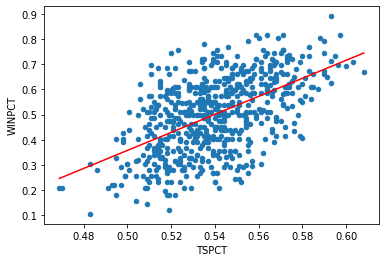

In [138]:
reg1 = smf.ols('WINPCT ~ TSPCT', df3).fit()
df3['yhat1'] = reg1.predict()
fig,ax = plt.subplots()
df3.plot.scatter(x='TSPCT', y='WINPCT', ax=ax)
df3.sort_values('TSPCT').set_index('TSPCT')['yhat1'].plot(ax=ax, color='r')

In [127]:
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     256.2
Date:                Tue, 04 May 2021   Prob (F-statistic):           1.45e-48
Time:                        16:40:50   Log-Likelihood:                 408.26
No. Observations:                 626   AIC:                            -812.5
Df Residuals:                     624   BIC:                            -803.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4315      0.121    -11.854      0.0

<AxesSubplot:xlabel='TOVPCT', ylabel='WINPCT'>

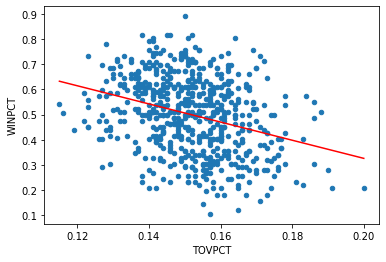

In [128]:
reg2 = smf.ols('WINPCT ~ TOVPCT', df3).fit()
df3['yhat2'] = reg2.predict()
fig,ax = plt.subplots()
df3.plot.scatter(x='TOVPCT', y='WINPCT', ax=ax)
df3.sort_values('TOVPCT').set_index('TOVPCT')['yhat2'].plot(ax=ax, color='r')

In [129]:
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     66.02
Date:                Tue, 04 May 2021   Prob (F-statistic):           2.40e-15
Time:                        16:40:57   Log-Likelihood:                 332.08
No. Observations:                 626   AIC:                            -660.2
Df Residuals:                     624   BIC:                            -651.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0461      0.067     15.503      0.0

<AxesSubplot:xlabel='OREBPCT', ylabel='WINPCT'>

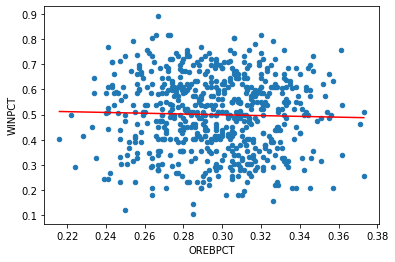

In [130]:
reg3 = smf.ols('WINPCT ~ OREBPCT', df3).fit()
df3['yhat3'] = reg3.predict()
fig,ax = plt.subplots()
df3.plot.scatter(x='OREBPCT', y='WINPCT', ax=ax)
df3.sort_values('OREBPCT').set_index('OREBPCT')['yhat3'].plot(ax=ax, color='r')

In [131]:
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5433
Date:                Tue, 04 May 2021   Prob (F-statistic):              0.461
Time:                        16:41:03   Log-Likelihood:                 300.87
No. Observations:                 626   AIC:                            -597.7
Df Residuals:                     624   BIC:                            -588.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5458      0.063      8.697      0.0

<AxesSubplot:xlabel='DREBPCT', ylabel='WINPCT'>

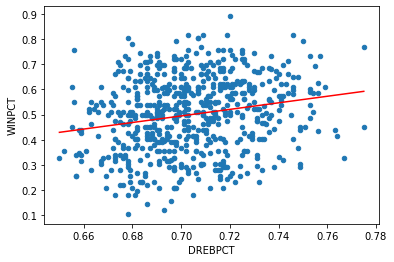

In [141]:
reg4 = smf.ols('WINPCT ~ DREBPCT', df3).fit()
df3['yhat4'] = reg4.predict()
fig,ax = plt.subplots()
df3.plot.scatter(x='DREBPCT', y='WINPCT', ax=ax)
df3.sort_values('DREBPCT').set_index('DREBPCT')['yhat4'].plot(ax=ax, color='r')

In [133]:
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     26.37
Date:                Tue, 04 May 2021   Prob (F-statistic):           3.78e-07
Time:                        16:41:11   Log-Likelihood:                 313.55
No. Observations:                 626   AIC:                            -623.1
Df Residuals:                     624   BIC:                            -614.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4159      0.178     -2.331      0.0

In [143]:
reg5 = smf.ols('WINPCT ~ OREBPCT + DREBPCT', df3).fit()
print(reg5.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     14.90
Date:                Tue, 04 May 2021   Prob (F-statistic):           4.78e-07
Time:                        16:45:37   Log-Likelihood:                 315.22
No. Observations:                 626   AIC:                            -624.4
Df Residuals:                     623   BIC:                            -611.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7106      0.240     -2.957      0.0

<AxesSubplot:xlabel='FTR', ylabel='WINPCT'>

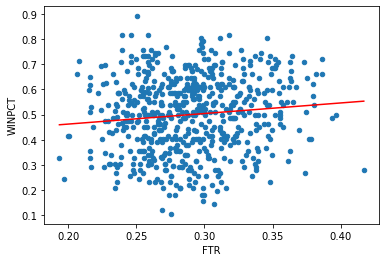

In [146]:
reg6 = smf.ols('WINPCT ~ FTR', df3).fit()
df3['yhat6'] = reg6.predict()
fig,ax = plt.subplots()
df3.plot.scatter(x='FTR', y='WINPCT', ax=ax)
df3.sort_values('FTR').set_index('FTR')['yhat6'].plot(ax=ax, color='r')

In [147]:
print(reg6.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.219
Date:                Tue, 04 May 2021   Prob (F-statistic):            0.00741
Time:                        16:46:52   Log-Likelihood:                 304.20
No. Observations:                 626   AIC:                            -604.4
Df Residuals:                     624   BIC:                            -595.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3785      0.046      8.318      0.0

In [151]:
reg7 = smf.ols('WINPCT ~ TSPCT + TOVPCT', df3).fit()
print(reg7.summary())

                            OLS Regression Results                            
Dep. Variable:                 WINPCT   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 04 May 2021   Prob (F-statistic):           1.81e-48
Time:                        17:06:10   Log-Likelihood:                 411.06
No. Observations:                 626   AIC:                            -816.1
Df Residuals:                     623   BIC:                            -802.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1356      0.174     -6.539      0.0

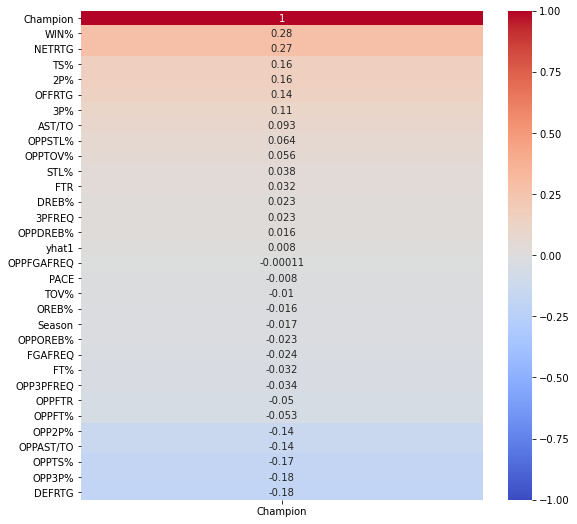

In [190]:
corr = df.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr[['Champion']].sort_values(by=['Champion'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);